# fMRI Session 01: Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white', context='notebook', font_scale=1.5)
%matplotlib inline

In today's demonstration, we will show you how to generate the predicted BOLD signal of a simple block design fMRI experiment. In fact, we will be making the predicted BOLD signal for an experiment run by a couple of PNI graduent students a few years ago (more on that later).

Today's demonstration will be in three parts: 
- Part 1: Make the hemodynamic response (HRF) in python
- Part 2: Make the predicted BOLD signal using a stimulus function and the HRF
- Part 3: Perform a regression analysis on simulated data using the signal from Part 2

## Section 0: Installing `nibabel`/`fmritools`

For today and Wednesday's demos, we will be using two fMRI-specific python packages (one written by PNI graduate students): `nibabel` and `fmritools`. To install the packages, open a terminal and run:

```bash
pip install nibabel
pip install git+https://github.com/szorowi1/neu350.git
```

## Section 1: Defining the HRF
To predict how the BOLD signal should evolve in response to some stimulus, we need to define the shape of the hemodynamic resposne function (HRF). As a reminder, the HRF is the predicted shape of the BOLD signal in response to an instaneous stimulus. Much like the action potential, the canonical HRF has two distinct phases: an initial **rising phase** and a subsequent prolonged **undershoot**. In general, the rising phase peaks around 6s and the trough of the undershoot occurs around 16s. 

Traditionally, the shape of the HRF is modeled by the superposition of two **[gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution)**. Neuroscientists use the gamma distribution because it is right-tailed. This asymmetry nicely captures what is typically observed of the HRF.

To create a HRF, we will import the `spm_hrf` function from `fmritools`. This function has several parameters that will let you create HRFs of arbitrary shape:

- **t1:** Delay of response relative to onset (in seconds), aka the length of the rising phase.
- **t2:** Delay of undershoot relative to onset (in seconds).
- **d1:** Dispersion of response, or the width of the rising phase.
- **d2:** Dispersion of undershoot, or the width of the undershoot.
- **ratio:** The size of the response relative to the undershoot.

Importantly, the `spm_hrf` function requires the **repetition time (TR)** as its first input. The TR is the sampling frequency of an fMRI experiment, or how often we acquire one complete image of the brain. The TR defines the smoothness of the idealized HRF. 

In the cell below, try plugging in different values to the `spm_hrf` function and see the HRF it produces. What values of the five parameters above create an HRF that most resembles what you saw in lecture?

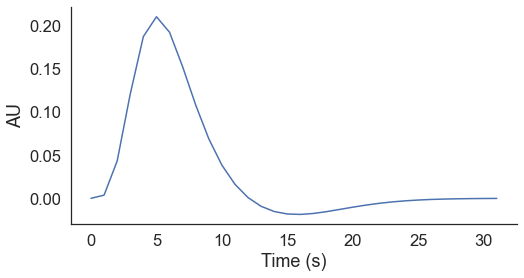

In [2]:
from fmritools.hrf import spm_hrf

## Define repetition time and times.
tr = 1.0
times = np.arange(0, 32, tr)

## PLUG IN VALUES HERE.
hrf = spm_hrf(tr, t1=6, t2=16, d1=1, d2=1, ratio=6)

## Plotting.
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(times, hrf)
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

## Section 2: Making the predicted BOLD signal

In this second section, we will use the HRF you defined above to generate the predicted BOLD signal in response to a simple block design fMRI experiment. In this experiment, participants were asked alternating blocks of a [visual checkerboard](https://www.youtube.com/watch?v=xEd1h_lz4rA) (warning: flashing lights) and an empty black background. Each stimulus (i.e. checkerboard, blank screen) was presented for 20 seconds a time. 

In this experiment, participants viewed six total blocks (i.e. 6 checkerboard presentations, 6 background presentations). Images were collected at a rate of 1 acquisition per second (TR=1). Though this paradigm is simple, we use it because it robustly excites neurons in early visual cortex (V1/V2).

To generate for this experiment its predicted BOLD signal, we need to perform the following steps:
1. Define the stimulus times.
2. Generate the neural "boxcars".
3. Convolve the boxcar timeseries with the HRF.

We will perform each step in turn below.

### [1] Define times

Because fMRI data is timeseries data (i.e. the change in the BOLD signal over the course of an experiment), we must start first by defining the timing of our experiment. Here, the the timing will be defined with respect to when each brain volume (3d brain picture) was collected. 

The experiment was conducted at TR=1, such that there was one brain volume per second. In the cell below, make a new variable `times` that contains the timestamp for each sample up to the total length of the experiment (remember: the experiment is comprised of 12 blocks of stimuli, each 20s long). 

In [3]:
## Define experiment metadata.
n_times = 6 * 20 + 6 * 20
sfreq = 1

## Define (super-sampled) times.
times = np.arange(0, n_times, sfreq)

### [2] Generate boxcar function

Now that we have defined the overall timing of the experiment, we must define when in the experiment events took place. In the present experiment, the events are the onset and offset of the visual checkerboard. 

To represent the checkerboard stimulus, we will define a "boxcar" timeseries. The boxcar timeseries is made up of 1s and 0s corresponding to when the checkerboard was present and absent, respectively. The total timeseries will indicate all the timestamps when the visual checkerboard was on versus when it was off.

In the cell below, define the onsets and offsets (in seconds) of each block of visual checkerboard.

In [4]:
## Define experiment events.
events = [(0,20),(40,60),(80,100),(120,140),(160,180),(200,220)]

Next, we will make the the boxcar timeseries. To do so, we will make a new array, `boxcars`, the same length of `times` that is comprised entirely of zeros. (Hint: you can use `np.zeros_like`). Then using `times` and the onsets/offsets you defined, index into this array and set all samples corresponding to a checkerboard event to 1.

In [5]:
## Generate boxcars.
boxcars = np.zeros_like(times)
for onset, offset in events:
    boxcars[np.logical_and(times >= onset, times < offset)] = 1

Plot this new array to see what it looks like. Does it look like boxcars? 

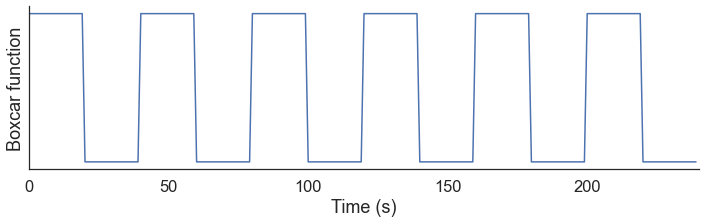

In [6]:
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, boxcars);
ax.set(xlim=(0,n_times), xlabel='Time (s)', yticks=[], ylabel='Boxcar function')
sns.despine()

### [3] Convolution

In this final step, we will use the boxcar timeseries and the HRF function (defined in Section 1) to make a new timeseries variables, `bold`, which is the expected BOLD response to the visual checkerboard. To make this new variable, we will use convolution.  

Convolution describes a particular mathematical operation where we use two functions to produce a third function that expresses how the shape of one is modified by the other. A nice visual illustration of convolution is [shown here](https://larzeitlin.github.io/images/3.3.gif). In this case, we convolve the boxcars with the HRF to model how we expect the BOLD signal to change in response to the checkerboard stimulus with time.

To perform convolution, we will use `np.convolve` inserting our `boxcars` array first, followed by `hrf`. Store the output of this operation in a new variable, `bold`.

In [7]:
## Convolve boxcars + HRF.
bold = np.convolve(boxcars, hrf)

Next we perform two small steps: First, you may notice the new variable `bold` is longer than `times`. This is an artifact of the convolution. Make `bold` as long as `times` by trimming the last N samples from the array.

In [8]:
## Trim.
bold = bold[:times.size]

Second, we normalize `bold` so that its max value is equal to 1. (This will help us in the regression below.) Normalize `bold` by dividing it by its current max value.

In [9]:
## Normalize regressor.
bold /= bold.max()

Plot this new array relative to boxcars. How does it look?

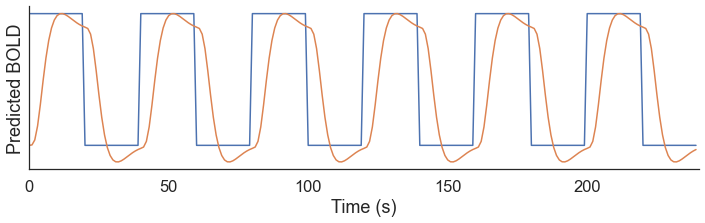

In [10]:
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, boxcars);
ax.plot(times, bold);
ax.set(xlim=(0,n_times), xlabel='Time (s)', yticks=[], ylabel='Predicted BOLD')
sns.despine()

## Section 3: Regression on simulated data

In this final section for today, we will use the predicted BOLD signal you generated and use it to perform linear regression with simulated BOLD data. 

### [1] Load and visualize data

In this step we will load in some data simulated to look like actual BOLD data.

In [11]:
## Load and extract data.
npz = np.load('fmri-01-data.npz')

## Extract the times and simulated data.
times = npz['times']
y = npz['y']
print('times:', times.shape)
print('y:', y.shape)

times: (240,)
y: (240, 20)


The variable `y` is a matrix of simulated fMRI voxels, or 20 BOLD timeseries each 240s long. The simulated data have been normalized to be in the units of **percent signal change**. In other words, the magnitude of each value correspond to how many percent the signal changes from baseline.

Plot the simulated data below. Does it look like the predicted BOLD timeseries?

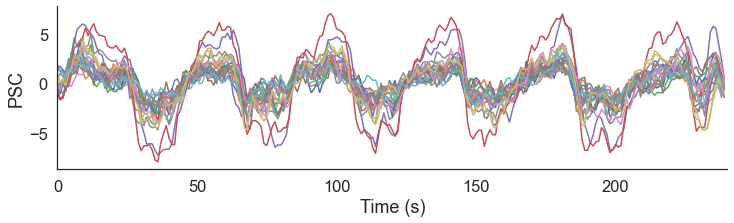

In [12]:
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y);
ax.set(xlim=(0,n_times), xlabel='Time (s)', ylabel='PSC')
sns.despine()

### [2] Construct design matrix

In statistics, a design matrix, `X`, (also known as model matrix or regressor matrix), is a matrix of values of explanatory variables of a set of objects. That is, its a set of timeseries we use to predict our observed (simulated) BOLD data.

In our case, our design matrix will be comprised of two arrays: an *intercept* and `bold` timeseries. The intercept is just an array made entirely of 1s. Using `np.ones_like` and `np.column_stack`, make our design matrix `X` in the cell below.

In [13]:
## Make the design matrix.
X = np.column_stack([np.ones_like(bold), bold])

### [3] Regression

In this final step, we will regress our design matrix against the simulated BOLD data. In our regression, we will solve for **coefficients** that map each regressor (i.e. column in the design matrix) to the observed data. Importantly, the coefficients tell us by how much our regressors need to be scaled to best predict the data. In our case, the coefficients tell us by how many percent the BOLD signal of one voxel changed in response to the checkerboard stimulus.

To perform the regression, we use `np.linalg.lstsq`. We provide the syntax below. The coefficients are stored in `coef`.

In [14]:
## Perform regression.
coef, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
print(coef.shape)

(2, 20)


Make a histogram of the coefficients corresponding to our predicted BOLD signal. By how many percent did the simulated BOLD signal change in response to the visual checkerboard?

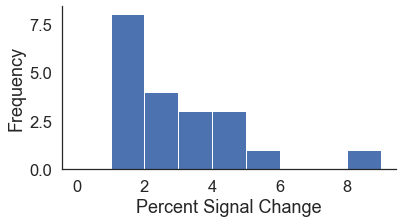

In [15]:
## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(coef[1], bins=np.arange(0,10))
ax.set(xlabel='Percent Signal Change', ylabel='Frequency')
sns.despine()